## 将m4a转换为wav

In [2]:
import os

In [4]:
current_dir = os.getcwd() 
raw_samples_dir = os.path.join(current_dir, "raw_sound")
raw_samples = os.listdir(raw_samples_dir)
wav_samples_dir = os.path.join(current_dir, "wav_sound")
if not os.path.exists(wav_samples_dir):
    os.mkdir(wav_samples_dir)
for raw_sample in raw_samples:
    if "m4a" in raw_sample:
        src_path = os.path.join(raw_samples_dir, raw_sample)
        dst_name = raw_sample.replace("m4a", "wav")
        dst_path = os.path.join(wav_samples_dir, dst_name)
#         注意下面的命令行指令必须指明ffmpeg的完整路径，否则无法进行转换
        cmd_command = r"D:\ffmpeg-2021-10-18-git-d04c005021-full_build\ffmpeg-2021-10-18-git-d04c005021-full_build\bin\ffmpeg.exe -i {0} -acodec pcm_s16le -ac 1 -y {1}".format(src_path, dst_path)
        os.system(cmd_command)

## 提取语音详细信息与绘制语音时域波形

In [1]:
import wave
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display

In [3]:
def read_wav_data(filename):
    wav = wave.open(filename, "rb")
    num_frame = wav.getnframes() # 获取帧数
    num_channel=wav.getnchannels() # 获取声道数
    framerate=wav.getframerate() # 获取帧速率
    num_sample_width=wav.getsampwidth() # 获取实例的比特宽度，即每一帧的字节数
    str_data = wav.readframes(num_frame) # 读取全部的帧
    wav.close() # 关闭流
    wave_data = np.fromstring(str_data, dtype = np.short) # 将声音文件数据转换为数组矩阵形式
    wave_data.shape = -1, num_channel # 按照声道数将数组整形，单声道时候是一列数组，双声道时候是两列的矩阵
    wave_data = wave_data.T # 将矩阵转置
    wave_data = wave_data 
    return wave_data, framerate

In [12]:
def wav_show(wave_data, fs, title):
    time = np.arange(0, len(wave_data)) * (1.0/fs)
    plt.plot(time, wave_data)
    plt.title(title)
    #plt.show()

c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


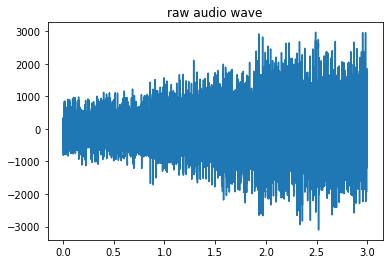

In [13]:
### 不使用预处理，直接使用wav读取原始wav音频文件，得到的音频序列
# current_dir = os.getcwd()
# wav_samples_dir = os.path.join(current_dir, "wav_sample")
# wav_samples = os.listdir(wav_samples_dir)
# for wav_sample in wav_samples:
#     wav_file = os.path.join(wav_samples_dir, wav_sample)
#     wave_data, fs = read_wav_data(wav_file)
#     wav_show(wave_data[0], fs)
#     break
# wav_file = os.path.join(wav_samples_dir, wav_samples[0])
wav_file = r'G:\GTA_audios\VAD_audio\15_40_small.wav'
wave_data, fs = read_wav_data(wav_file)
wav = wave_data[0]
wav_show(wav, fs, 'raw audio wave')

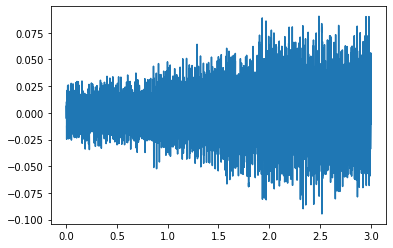

In [8]:
### 直接使用librosa.load，得到与上述绘制结果相同
times = librosa.get_duration(filename=wav_file)
wav, sr = librosa.load(wav_file, sr=None)
x = np.arange(0, times, 1.0/sr)
plt.plot(x, wav)
plt.show()

In [12]:
# for i, wav_sample in enumerate(wav_samples):
#     wav_file = os.path.join(wav_samples_dir, wav_sample)
#     wave_data, fs = read_wav_data(wav_file)
#     plt.figure(i)
#     wav_show(wave_data[0], fs)
#     plt.plot()

## 预加重

In [9]:
def pre_emphasis(wav_data, miu, mode="traditional"):
    signal_points = len(wav_data)
    signal_points = int(signal_points)
    if mode == "traditional":
        for i in range(1, signal_points, 1):
            wav_data[i] = wav_data[i] - miu * wav_data[i-1]
    elif mode == "updated":
        for i in range(1, signal_points, 1):
            wav_data[i] = wav_data[i] + miu * wav_data[i-1]
    else:
        print("no such mode")
    return wav_data

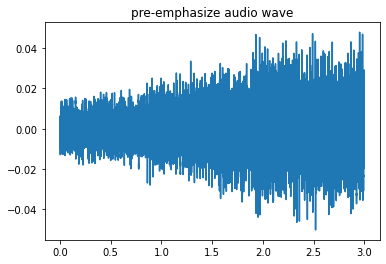

In [15]:
mode = "traditional" # traditional or updated
miu = 0.9375
times = librosa.get_duration(filename=wav_file)
wav, sr = librosa.load(wav_file, sr=None, mono=True, offset=0.0, duration=None)
pre_empha_wav = pre_emphasis(wav_data=wav, miu=miu, mode=mode)
x = np.arange(0, times, 1/sr)
plt.plot(x, pre_empha_wav)
plt.title('pre-emphasize audio wave')
plt.show()

## 归一化

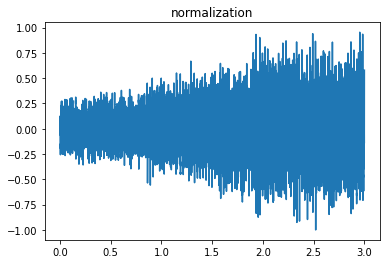

In [17]:
pre_empha_wav = pre_empha_wav * 1.0 / (max(abs(pre_empha_wav)))
x = np.arange(0, times, 1/sr)
plt.plot(x, pre_empha_wav)
plt.title('normalization')
plt.show()

## 分帧加窗

In [56]:
import scipy.signal as signal
import numpy as np

In [57]:
def enframe(signal, nw, inc, winfunc):
    signal_length = len(signal)
    if signal_length <= nw:
        n_frames = 1
    else:
        n_frames = int(np.ceil((1.0*signal_length - nw + inc) / inc))
#     print(n_frames)
    pad_length = int((n_frames - 1) * inc + nw) # 分帧后总长度
    zeros = np.zeros((pad_length - signal_length, )) # 不够的长度用0来填补
    pad_signal = np.concatenate((signal, zeros))
    indices = np.tile(np.arange(0, nw), (n_frames, 1))
    increment = np.tile(np.arange(0, n_frames * inc, inc), (nw, 1)).T
    indices += increment
    indices = np.array(indices, dtype=np.int32)
    frames = pad_signal[indices]
    win = np.tile(winfunc, (n_frames, 1))
    return frames * win

In [58]:
nw = 512
inc = 128
winfunc = signal.windows.hamming(nw)
frames = enframe(pre_empha_wav, nw, inc, winfunc)

## 短时能量

In [60]:
def calEnergy(frame):
    sumEnergy = 0
    for i in frame:
        sumEnergy += np.abs(i)
    return sumEnergy

In [61]:
energy = []
for frame in frames:
    energy.append(calEnergy(frame))

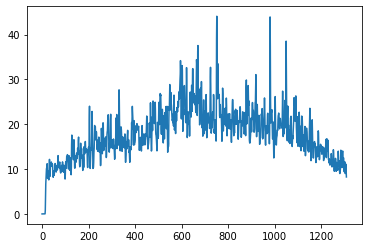

In [62]:
plt.plot(energy)
plt.show()

## 短时过零率

In [63]:
def sgn(data):
    if data >= 0:
        return 1
    else:
        return -1

In [64]:
def calZeroCrossingRate(frame):
    sum = 0
    for i in range(1, len(frame)):
        sum += np.abs(sgn(frame[i]) - sgn(frame[i-1]))
    sum = float(sum) / 1024
    return sum

In [65]:
zeroCrossingRate = []
for frame in frames:
    zeroCrossingRate.append(calZeroCrossingRate(frame))

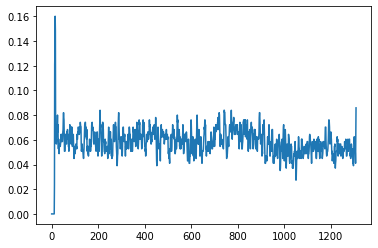

In [66]:
plt.plot(zeroCrossingRate)
plt.show()

In [67]:
test = librosa.feature.zero_crossing_rate(pre_empha_wav, frame_length=512, hop_length=128, center=False)

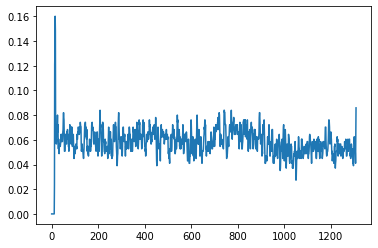

In [68]:
plt.plot(test[0])
plt.show()

## 端点检测

In [69]:
mean_energy = np.mean(np.array(energy))
energy = [i-mean_energy for i in energy]
for i in range(len(energy)):
    if energy[i] < 0:
        energy[i] = 0

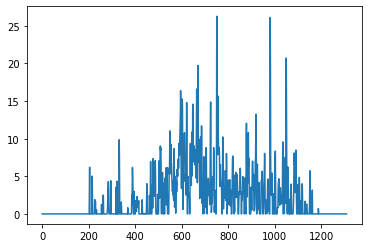

In [70]:
plt.plot(energy)
plt.show()

In [71]:
def endPointDetect(energy, zeroCrossingRate):
    energy_length = len(energy)
    energyAverage = 0
    sum = 0
    count = 0
    for en in energy:
        if en > 0:
            sum += en
            count += 1
#     energyAverage = sum / energy_length
    energyAverage = sum / count
    sum = 0
    for en in energy[int(energy_length/4)-2:int(energy_length/4)+2]:
        sum += en
    ML = sum / 5
    MH = energyAverage / 3
    ML = (ML + MH) / 4
    
    sum = 0
    for zcr in zeroCrossingRate[int(energy_length/2)-2:int(energy_length/2)+2]:
        sum = float(sum) + zcr
    Zs = sum
    
    A = []
    B = []
    C = []
    # 首先利用较大能量阈值 MH 进行初步检测
    flag = 0
    for i in range(len(energy)):
        if len(A) == 0 and flag == 0 and energy[i] > MH:
            A.append(i)
            flag = 1
        elif flag == 0 and energy[i] > MH and i - 21 > A[len(A)-1]:
            A.append(i)
            flag = 1
        elif flag == 0 and energy[i] > MH and i - 21 <= A[len(A)-1]:
            A = A[:len(A) - 1]
            flag = 1
        if flag == 1 and energy[i] < MH:
            A.append(i)
            flag = 0
    if flag == 1 and len(A) % 2 == 1:
        A.append(len(energy)-1)
#     print("较高能量阈值，计算后的浊音A:" + str(A))
    # 利用较小能量阈值 ML 进行第二步能量检测
    for j in range(len(A)):
        i = A[j]
        if j%2 == 1:
            while i<len(energy) and energy[i] > ML:
                i += 1
            B.append(i)
        else:
            while i>0 and energy[i] > ML:
                i -= 1
            B.append(i)
#     print("较低能量阈值，增加一段语言B:" + str(B))
    # 利用过零率进行最后一步检测
    for j in range(len(B)):
        i = B[j]
        if j%2 == 1:
            while i<len(zeroCrossingRate) and zeroCrossingRate[i] >= 3*Zs:
                i += 1
            C.append(i)
        else:
            while i > 0 and zeroCrossingRate[i] >= 3*Zs:
                i -= 1
            C.append(i)
#     print("过零率阈值，最终语音分段C:" + str(C))
#     print(ML, MH, Zs)
    return C

## 测试

c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuff

c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuff

c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuff

c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
c:\users\57417\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuff

[]

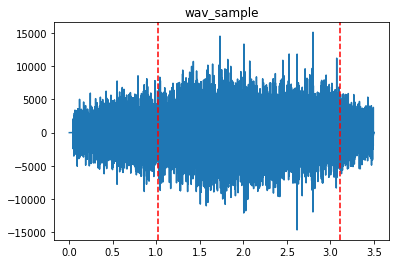

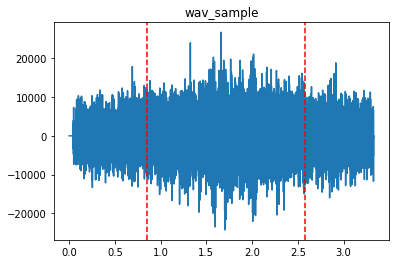

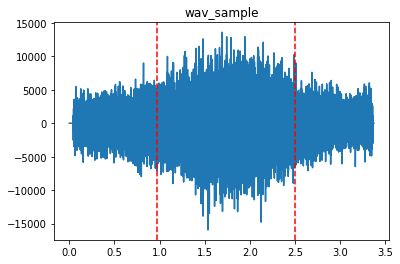

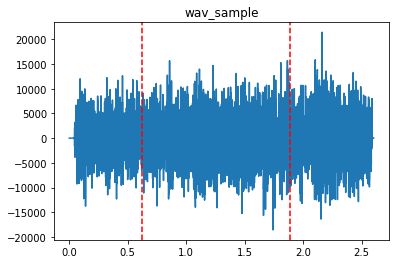

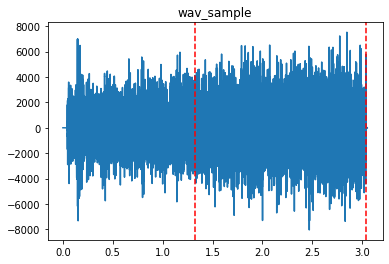

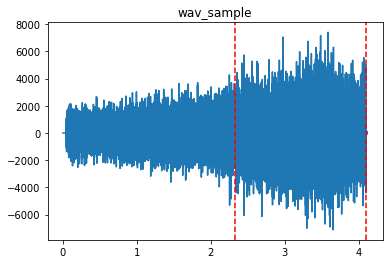

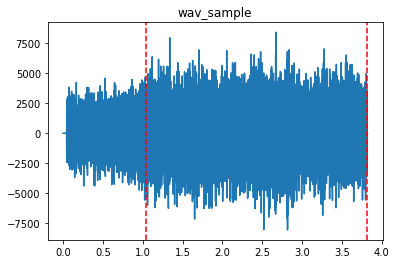

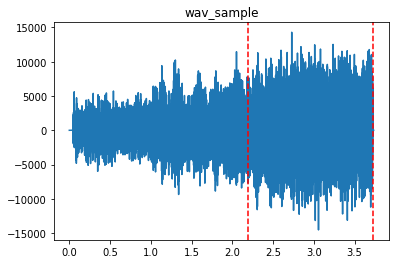

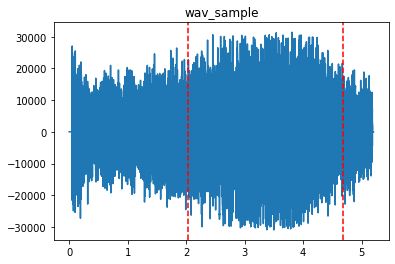

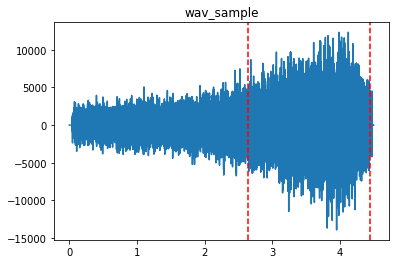

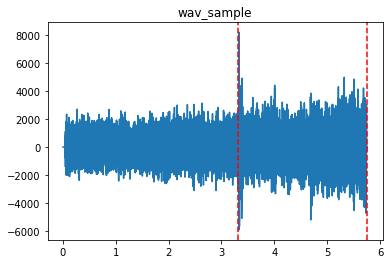

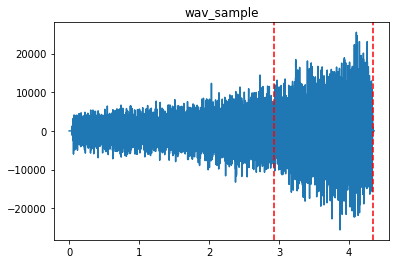

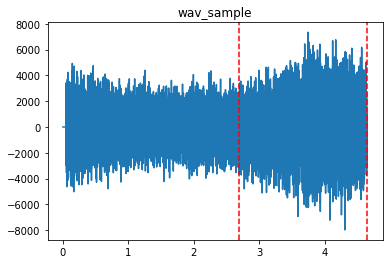

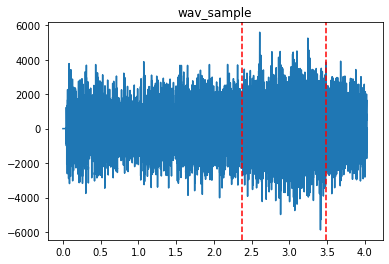

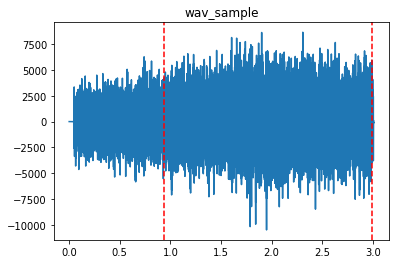

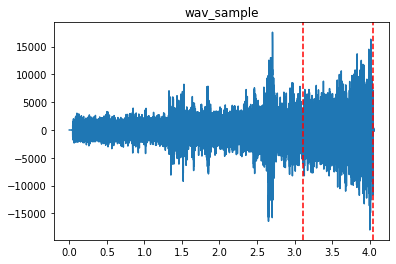

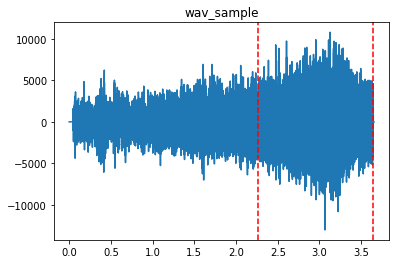

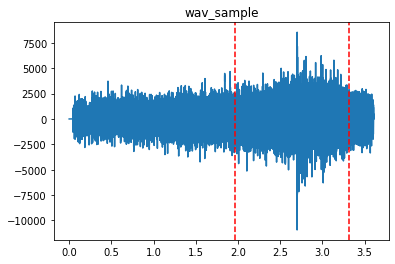

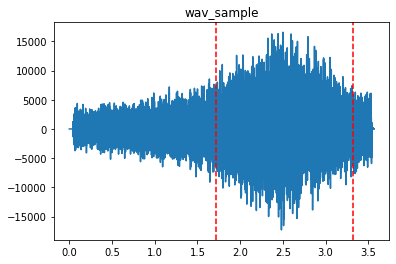

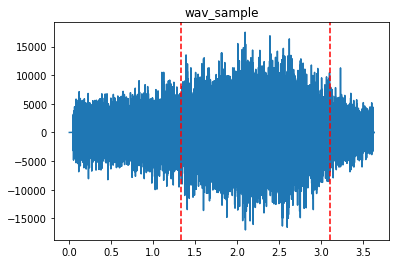

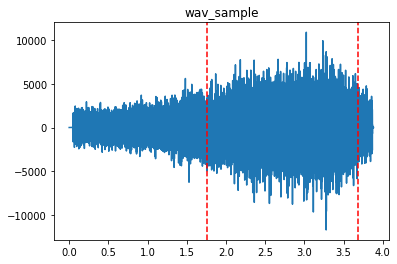

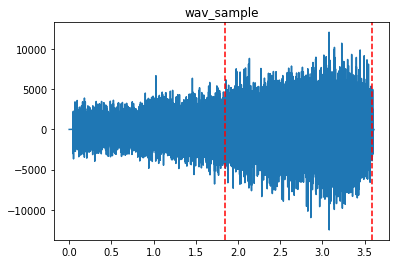

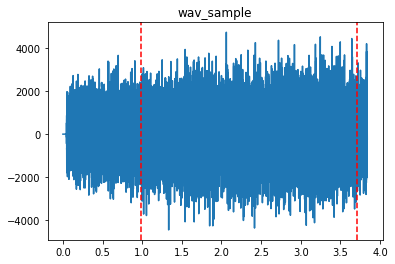

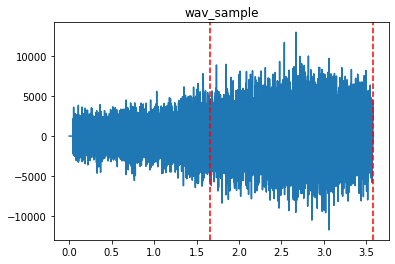

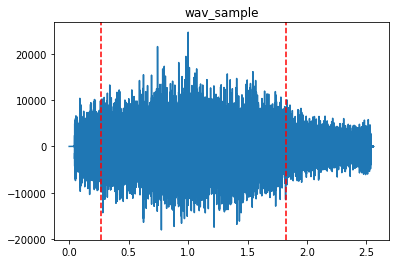

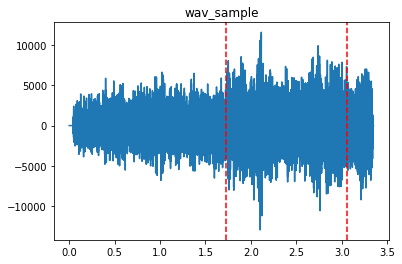

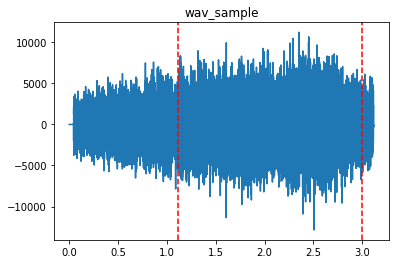

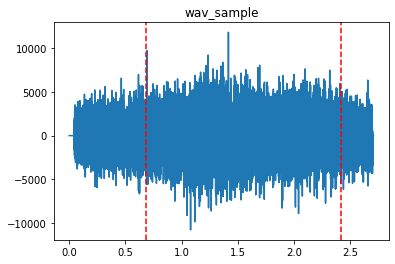

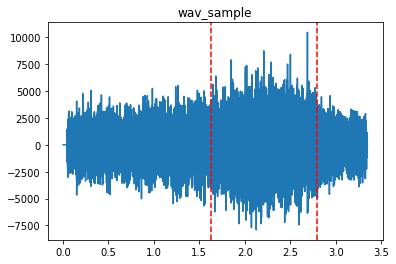

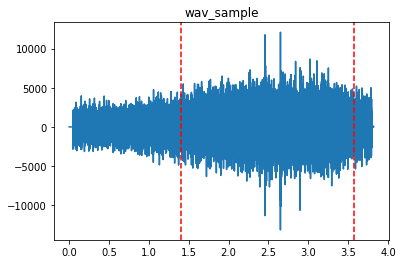

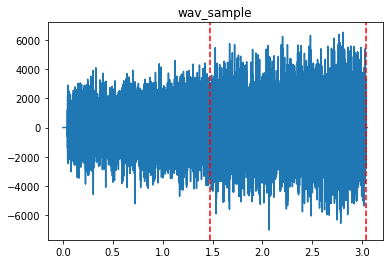

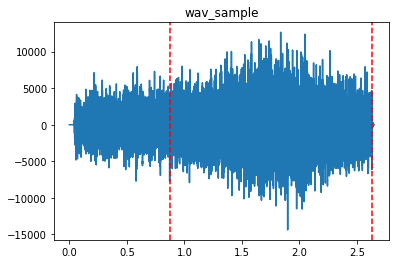

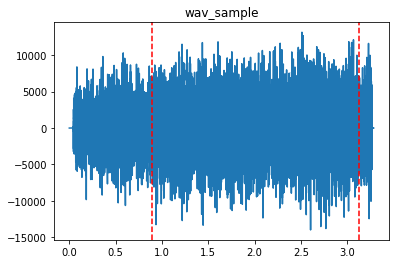

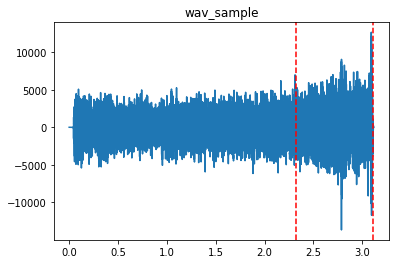

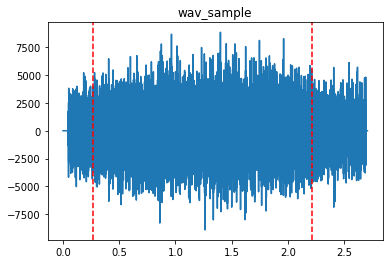

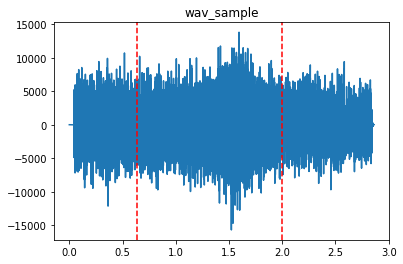

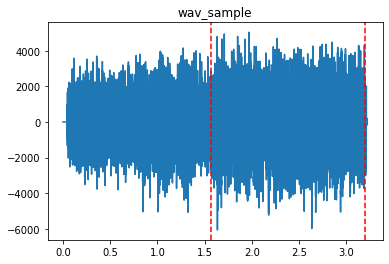

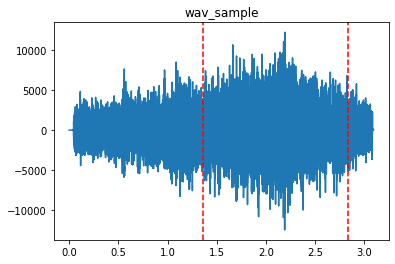

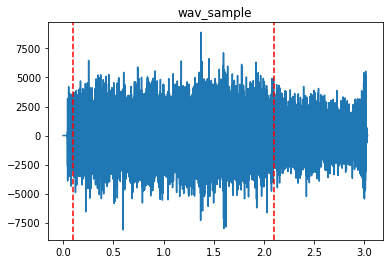

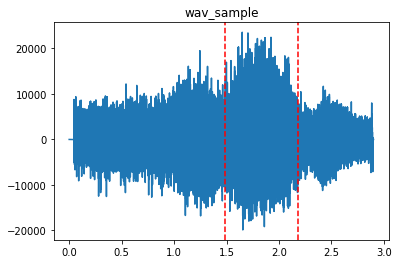

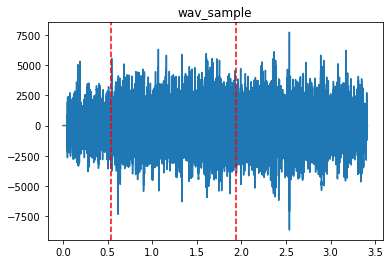

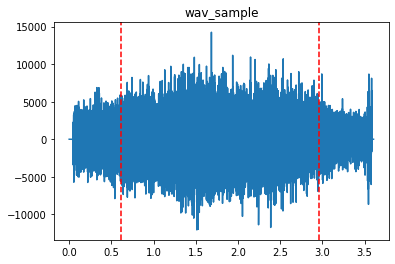

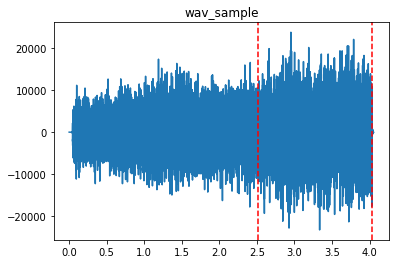

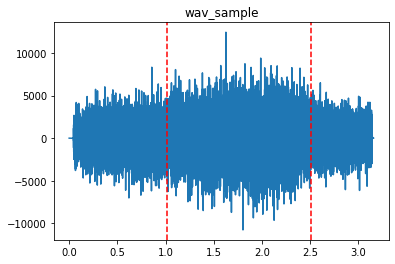

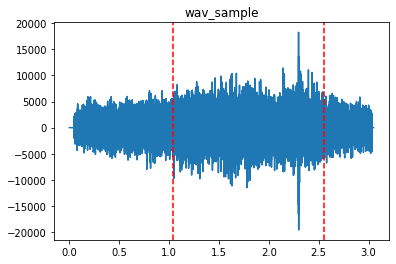

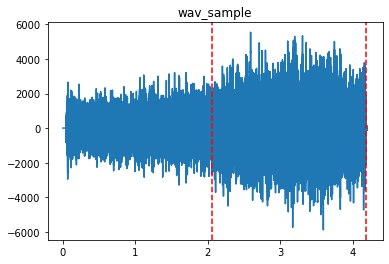

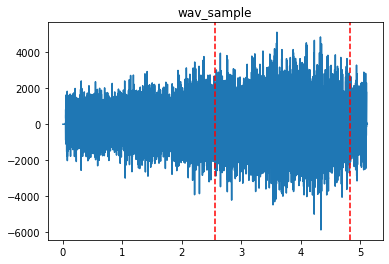

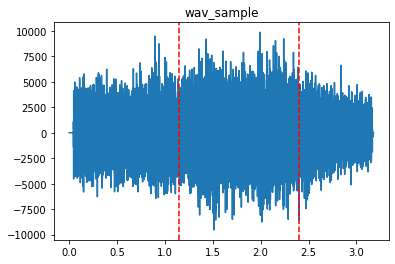

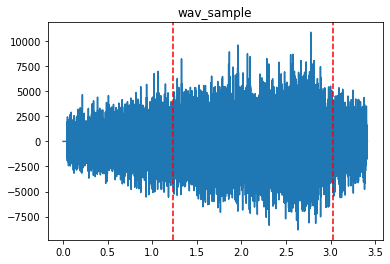

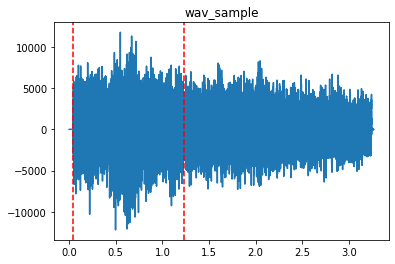

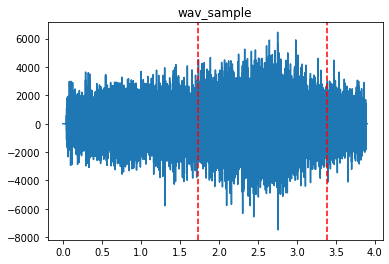

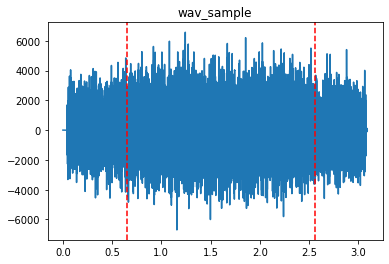

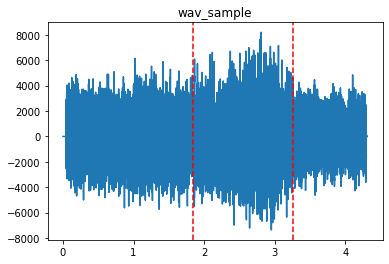

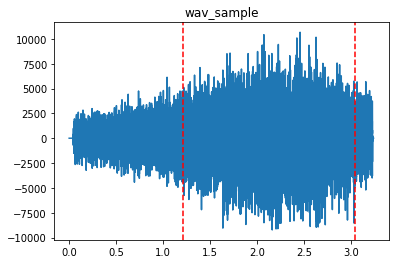

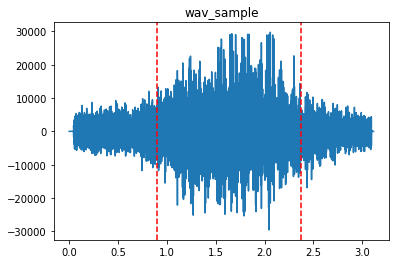

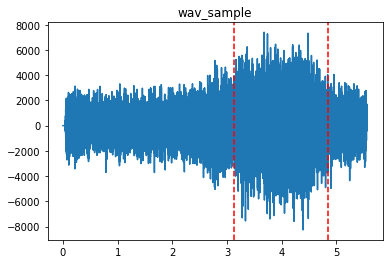

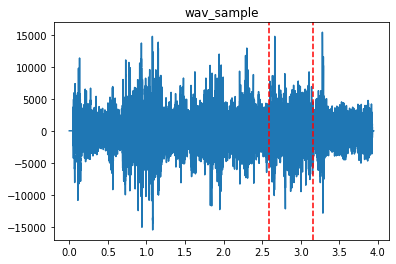

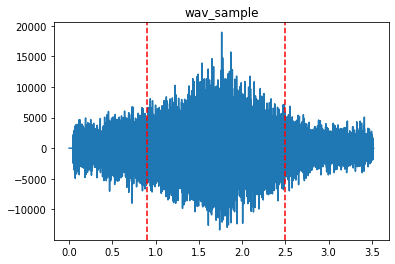

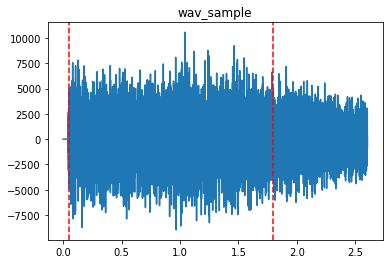

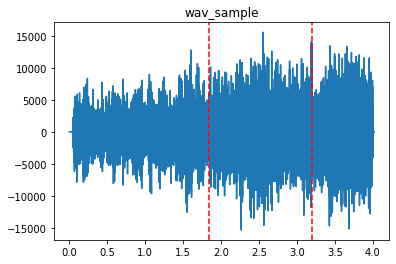

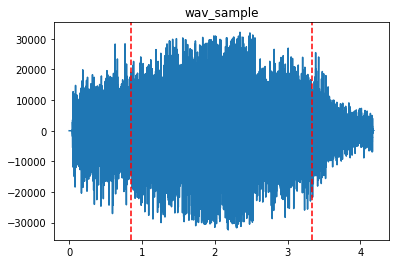

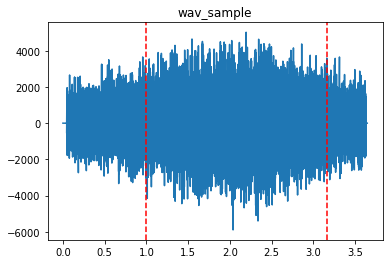

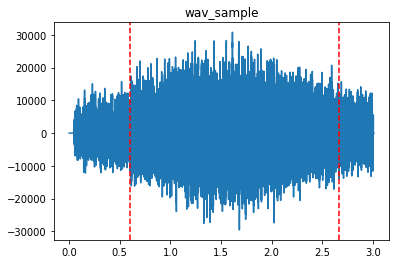

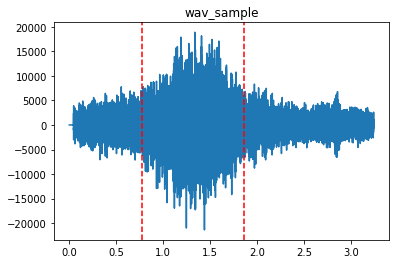

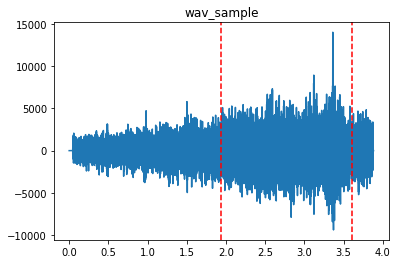

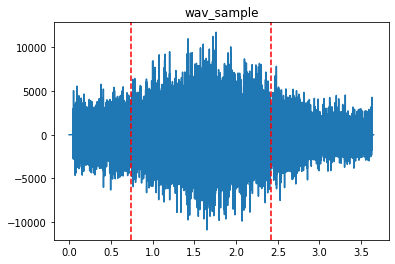

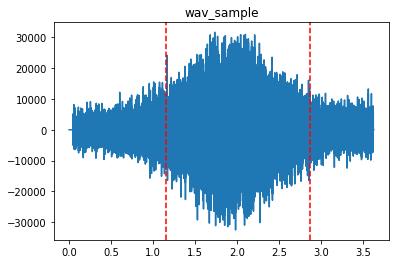

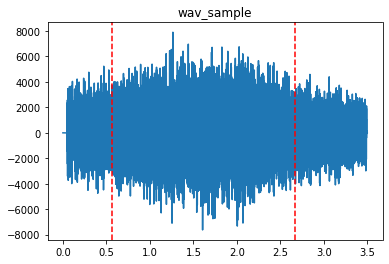

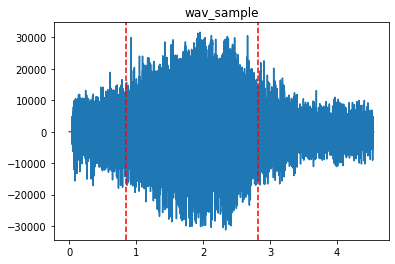

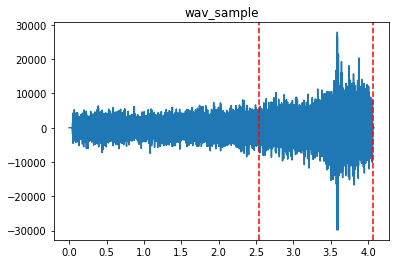

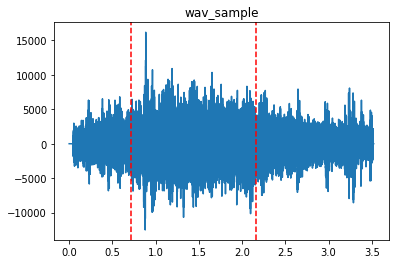

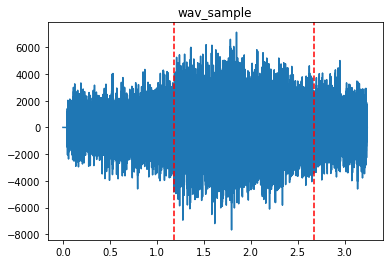

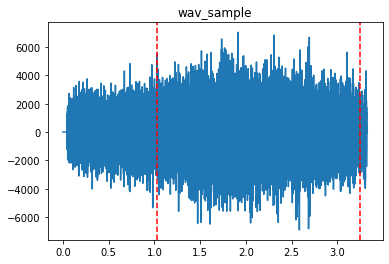

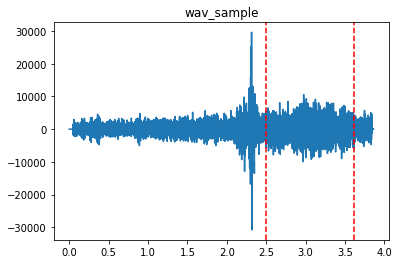

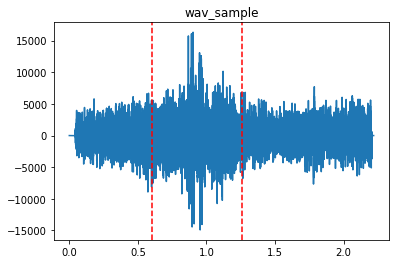

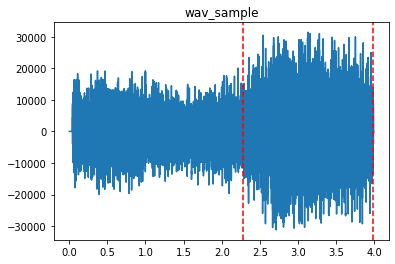

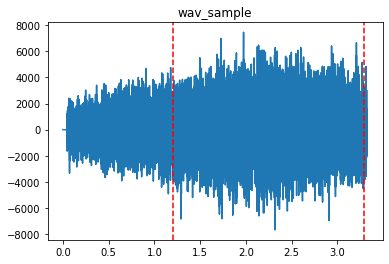

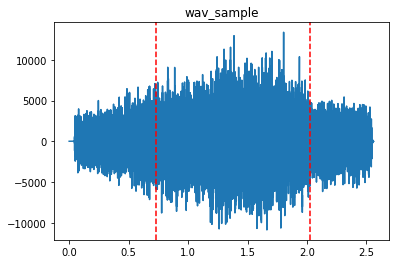

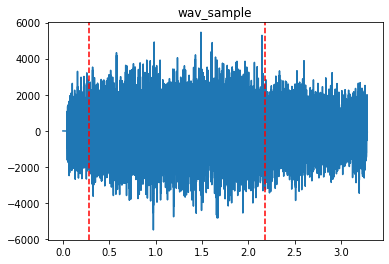

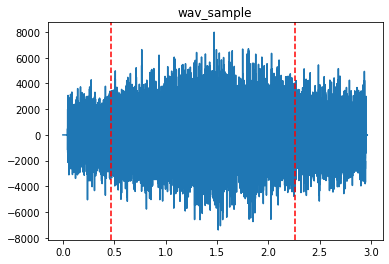

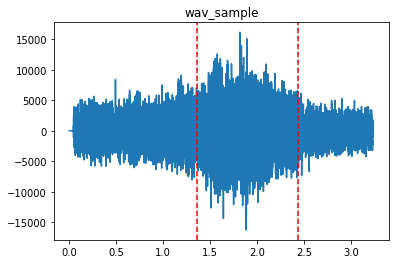

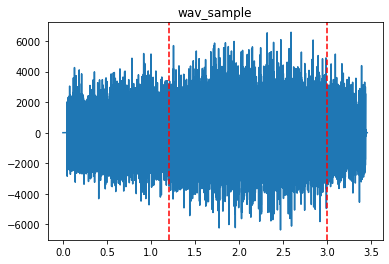

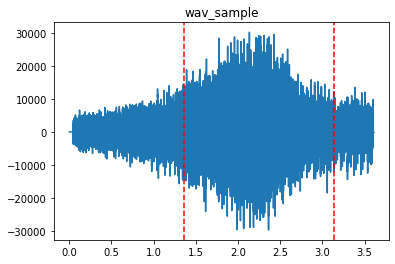

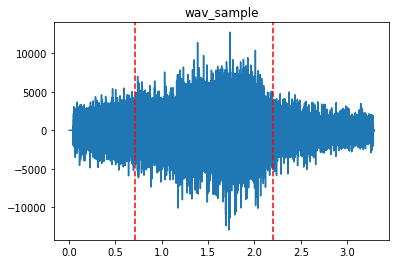

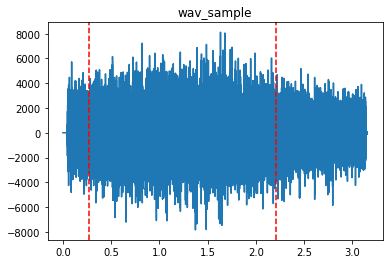

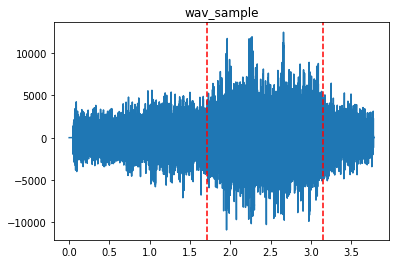

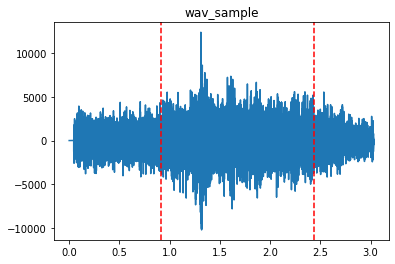

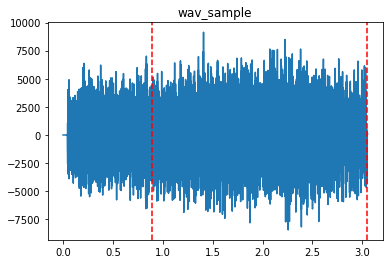

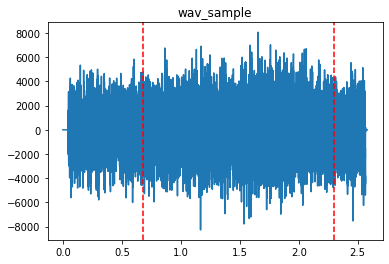

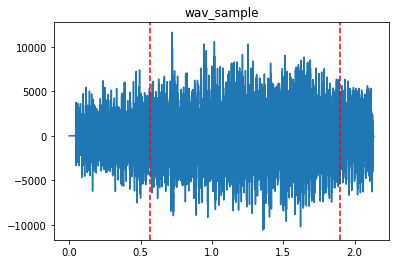

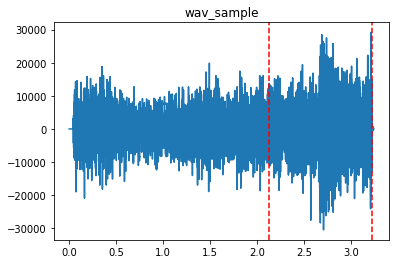

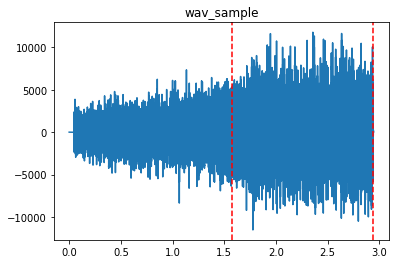

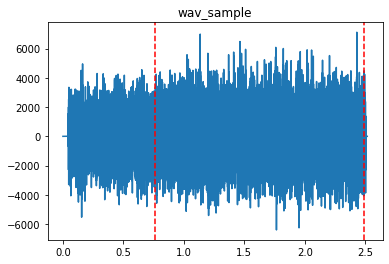

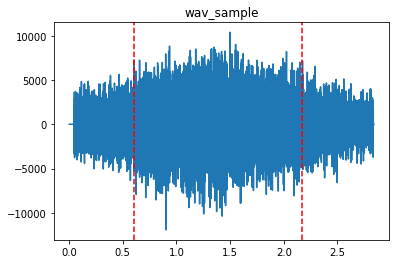

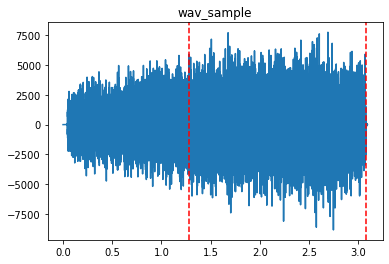

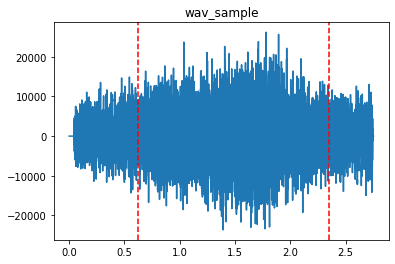

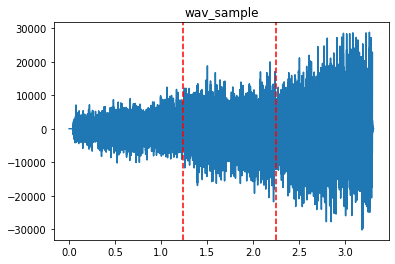

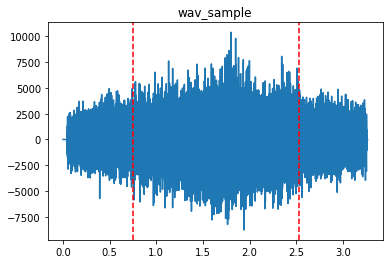

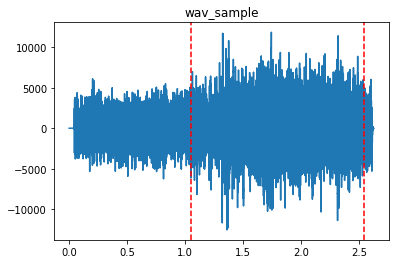

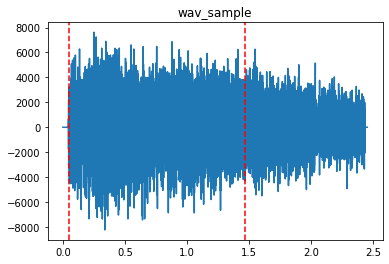

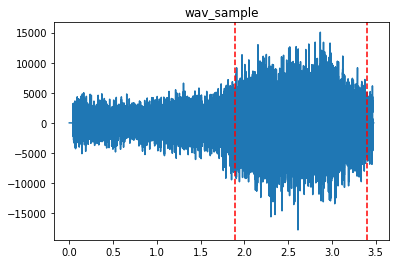

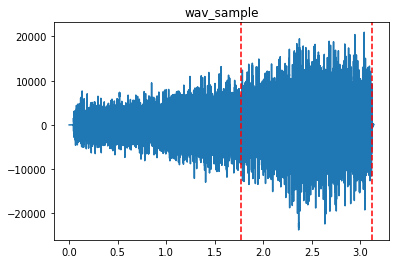

In [74]:
for i, wav_sample in enumerate(wav_samples):
    wav_file = os.path.join(wav_samples_dir, wav_sample)
    wave_data, fs = read_wav_data(wav_file)
    plt.figure(i)
    wav_show(wave_data[0], fs)
    plt.title("wav_sample")
    ## pre_emphasize
    times = librosa.get_duration(filename=wav_file)
    pre_empha_wav, sr = librosa.load(wav_file, sr=None, mono=True, offset=0.0, duration=None) ## 此处有问题，应进行归一化与预加重
    ## enframe
    nw = 512
    inc = 128
    winfunc = signal.windows.hamming(nw)
    frames = enframe(pre_empha_wav, nw, inc, winfunc)
    ## 短时能量

    energy = []
    for frame in frames:
        energy.append(calEnergy(frame))
    ## 短时过零率
    zeroCrossingRate = []
    for frame in frames:
        zeroCrossingRate.append(calZeroCrossingRate(frame))
    ## 端点检测
    mean_energy = np.mean(np.array(energy))
    energy = [en-mean_energy for en in energy]
    for j in range(len(energy)):
        if energy[j] < 0:
            energy[j] = 0
    C = endPointDetect(energy, zeroCrossingRate)
    distance = []
    for k in range(0, len(C), 2):
        distance.append(C[k+1] - C[k])
    indice = distance.index(max(distance))
    endPointList = [C[indice*2], C[indice*2+1]]
    startPoint = (endPointList[0]-1)*inc/sr
    endPoint = ((endPointList[1]-1)*inc+nw)/sr
    plt.axvline(startPoint, color="r", linestyle="--")
    plt.axvline(endPoint, color="r", linestyle="--")
plt.plot()

3.4986875

In [106]:
def plot_energy(wav_sample):
    wav_file = os.path.join(wav_samples_dir, wav_sample)
    wave_data, fs = read_wav_data(wav_file)
    mode = "traditional" # traditional or updated
    miu = 0.9375
    times = librosa.get_duration(filename=wav_file)
    wav, sr = librosa.load(wav_file, sr=None, mono=True, offset=0.0, duration=None)
    pre_empha_wav = pre_emphasis(wav_data=wav, miu=miu, mode=mode)
    nw = 512
    inc = 128
    winfunc = signal.windows.hamming(nw)
    frames = enframe(pre_empha_wav, nw, inc, winfunc)
    energy = []
    for frame in frames:
        energy.append(calEnergy(frame))
    mean_energy = np.mean(np.array(energy))
    energy = [i-mean_energy for i in energy]
    for i in range(len(energy)):
        if energy[i] < 0:
            energy[i] = 0
    plt.plot(energy)
    plt.show()